In [1]:
import sys
print(sys.executable)   # must match the .venv path from step 2


c:\Users\Asus\Desktop\DL_Project\.venv\Scripts\python.exe


In [2]:
import os
import numpy as np
import pandas as pd
from glob import glob
import cv2
import torch
from torch.utils import data
from PIL import Image
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

In [3]:
import os
os.makedirs('trains/images', exist_ok=True)
os.makedirs('trains/imagesf', exist_ok=True)

In [4]:
import shutil
import os

#  Source file (your annotation file)
source_file = r"C:\Users\Asus\Desktop\DL Data_Set\DLDB\train\TrainIJCNN2013\gt.txt"

#  Destination folder in your VS Code project
destination_dir = r"C:\Users\Asus\Desktop\DL_Project\data\gtsdb\annotations"

#  Make sure destination folder exists
os.makedirs(destination_dir, exist_ok=True)

#  Copy the file
shutil.copy(source_file, destination_dir)

print(" 'gt.txt' file copied successfully to:", destination_dir)



 'gt.txt' file copied successfully to: C:\Users\Asus\Desktop\DL_Project\data\gtsdb\annotations


In [5]:
import glob
import shutil
import os

#  Specify your local source directory and file type
source_dir = r"C:\Users\Asus\Desktop\DL Data_Set\DLDB\train\TrainIJCNN2013"
file_type = "*.ppm"

#  Specify your destination directory inside your VS Code project
destination_dir = r"C:\Users\Asus\Desktop\DL_Project\data\gtsdb\trains\images"

#  Create destination directory if it doesn’t exist
os.makedirs(destination_dir, exist_ok=True)

#  Find all .ppm files (recursively, includes subfolders)
files = glob.glob(os.path.join(source_dir, "**", file_type), recursive=True)

print(f"Found {len(files)} .ppm files.")

#  Copy each file to the destination directory
for file in files:
    shutil.copy(file, destination_dir)

print(" All .ppm files copied successfully to:", destination_dir)



Found 1453 .ppm files.
 All .ppm files copied successfully to: C:\Users\Asus\Desktop\DL_Project\data\gtsdb\trains\images


In [6]:
import os
from pathlib import Path

# === CONFIG: update these if your paths are different ===
# path to the gt.txt file (original annotations)
gt_path = Path(r"C:\Users\Asus\Desktop\DL Data_Set\DLDB\train\TrainIJCNN2013\gt.txt")

# optional: where you want to save a parsed CSV (not required)
out_csv = Path(r"C:\Users\Asus\Desktop\DL_Project\data\gtsdb\annotations\gt_parsed.csv")

# === helper to detect delimiter and parse lines ===
def detect_and_parse_line(line: str):
    line = line.strip()
    if not line:
        return None
    # detect delimiter: prefer semicolon, then comma, otherwise whitespace
    if ";" in line:
        parts = [p.strip() for p in line.split(";") if p.strip()]
    elif "," in line:
        parts = [p.strip() for p in line.split(",") if p.strip()]
    else:
        # split on any whitespace
        parts = line.split()
    return parts

# === main parsing function ===
def parse_gt_file(gt_path: Path):
    if not gt_path.exists():
        raise FileNotFoundError(f"gt file not found: {gt_path}")

    annotations = {}  # filename -> list of [x1,y1,x2,y2,label]
    with gt_path.open("r", encoding="utf-8") as f:
        for ln_no, raw in enumerate(f, start=1):
            parts = detect_and_parse_line(raw)
            if not parts:
                continue

            # Expect first token = filename
            filename = parts[0]
            # Remaining tokens should contain coords and label.
            # There are different possible layouts; try to be flexible:
            # Common case: filename x1 y1 x2 y2 label (5 numbers after name)
            try:
                # try to parse the last 5 tokens as numbers (x1,y1,x2,y2,label)
                last5 = parts[-5:]
                x1, y1, x2, y2 = map(float, last5[:4])  # coordinates may be float
                label = int(last5[4])
            except Exception:
                # If that didn't work, try parsing everything after filename as numbers and take sensible slicing
                numbers = []
                for token in parts[1:]:
                    try:
                        # Accept ints and floats
                        if "." in token:
                            numbers.append(float(token))
                        else:
                            numbers.append(int(token))
                    except Exception:
                        # non-numeric token (skip)
                        pass
                if len(numbers) >= 5:
                    x1, y1, x2, y2 = map(float, numbers[:4])
                    label = int(numbers[4])
                else:
                    # can't parse this line — skip with a warning
                    print(f"Warning: couldn't parse line {ln_no}: {raw.strip()}")
                    continue

            target = [x1, y1, x2, y2, label]

            # store in dictionary
            if filename in annotations:
                annotations[filename].append(target)
            else:
                annotations[filename] = [target]

    return annotations

# === run it ===
annotations = parse_gt_file(gt_path)
print("Unique image files in gt:", len(annotations))
# example: show annotations for a sample image if present
sample = next(iter(annotations)) if annotations else None
if sample:
    print("Sample image:", sample)
    print("Annotations for sample:", annotations[sample])

# === optional: write parsed CSV (one row per object) ===
def dump_parsed_csv(annotations: dict, out_path: Path):
    out_path.parent.mkdir(parents=True, exist_ok=True)
    with out_path.open("w", encoding="utf-8") as f:
        f.write("filename,x1,y1,x2,y2,label\n")
        for fname, objs in annotations.items():
            for (x1,y1,x2,y2,label) in objs:
                f.write(f"{fname},{x1},{y1},{x2},{y2},{label}\n")
    print("Parsed CSV written to:", out_path)

# Uncomment to create parsed CSV
# dump_parsed_csv(annotations, out_csv)


Unique image files in gt: 506
Sample image: 00000.ppm
Annotations for sample: [[774.0, 411.0, 815.0, 446.0, 11]]


In [8]:
# --- THIS IS THE CORRECTED CODE FOR YOUR 'dic' ---

import numpy as np

print("Loading annotations...")
# Corrected path (using raw string)
txt = np.genfromtxt(r'C:\Users\Asus\Desktop\DL Data_Set\DLDB\train\TrainIJCNN2013\gt.txt',
                  delimiter=';', dtype=None, encoding=None) # type: ignore

# Create a dictionary with image names as key and annotations as value
dic = {}
print(f"Found {len(txt)} total annotations.")

for i in range(len(txt)):
    # Image name is the first element
    img_name = txt[i][0]
    
    # --- THIS IS THE FIX ---
    # Your model needs labels from 1 to 43.
    # Your data has labels from 0 to 42.
    # We must add +1 to every label.
    original_label = int(txt[i][5])
    new_label = original_label + 1  # Map 0->1, 1->2, ..., 42->43
    # --- END OF FIX ---

    # Bounding box coordinates
    bbox = [int(txt[i][1]), int(txt[i][2]), int(txt[i][3]), int(txt[i][4])]
    
    # Store as a DICTIONARY (as expected by dataset.py)
    annotation = {'bbox': bbox, 'label': new_label} # <-- Use the NEW, +1 label
    
    # Store as list of dictionaries
    if img_name in dic:
        dic[img_name].append(annotation)
    else:
        dic[img_name] = [annotation]

print(f"Loaded {len(dic)} images with mapped annotations.")
print("Number of Images:", len(dic))

# --- END OF 'dic' CODE ---

Loading annotations...
Found 852 total annotations.
Loaded 506 images with mapped annotations.
Number of Images: 506


In [9]:
dic['00001.ppm']

[{'bbox': [983, 388, 1024, 432], 'label': 41},
 {'bbox': [386, 494, 442, 552], 'label': 39},
 {'bbox': [973, 335, 1031, 390], 'label': 14}]

## DATA DISTRIBUTION


In [10]:
cls_lst = {}

for i in dic:
    for j in dic[i]:
        # --- THIS IS THE FIX ---
        # Get the label by its key, not by its index
        cls = j['label']  
        # -----------------------

        if cls in cls_lst:
            cls_lst[cls] += 1
        else:
            cls_lst[cls] = 1

print(cls_lst)

{12: 26, 41: 7, 39: 57, 14: 52, 40: 4, 5: 31, 10: 32, 22: 5, 3: 59, 13: 54, 2: 48, 26: 21, 31: 14, 24: 13, 28: 3, 36: 15, 16: 10, 34: 13, 29: 9, 19: 27, 37: 8, 27: 11, 38: 1, 35: 9, 1: 4, 25: 2, 15: 22, 21: 9, 30: 4, 7: 17, 11: 63, 9: 47, 6: 37, 17: 7, 20: 2, 18: 25, 4: 21, 8: 37, 42: 6, 32: 1, 23: 9, 43: 7, 33: 3}


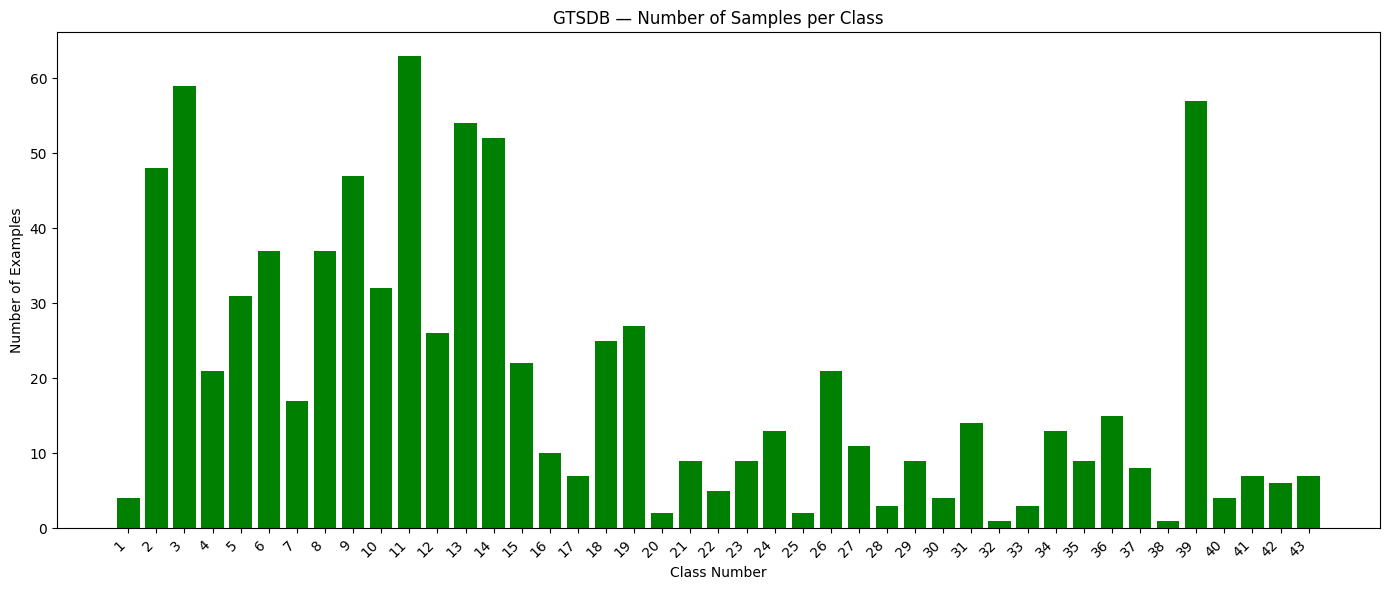

In [11]:
import matplotlib.pyplot as plt

normalized = {int(k): v for k, v in cls_lst.items()}
sorted_classes = sorted(normalized.keys())
xx = [str(c) for c in sorted_classes]
yy = [normalized[c] for c in sorted_classes]

plt.figure(figsize=(14,6))
x_pos = range(len(xx))
plt.bar(x_pos, yy, color='green')
plt.xticks(x_pos, xx, rotation=45, ha='right')
plt.xlabel("Class Number")
plt.ylabel("Number of Examples")
plt.title("GTSDB — Number of Samples per Class")
plt.tight_layout()
plt.show()



### Organizing the GTSDB Dataset:
Unzipping the dataset zip, there are class folders with respective images and .ppm files. There is also the annotation file named as gt.txt

I had copied all the .ppm files to a directory named "train/images".

In the code below, the images that had annotations were only copied to a new folder.

In [12]:
import os
import glob
import shutil

#  Path where all .ppm images are currently located
source_dir = r"C:\Users\Asus\Desktop\DL_Project\data\gtsdb\trains\images"

#  Path where only annotated images will be copied
destination_dir = r"C:\Users\Asus\Desktop\DL_Project\data\gtsdb\trains\imagesf"

#  Make sure destination folder exists
os.makedirs(destination_dir, exist_ok=True)

#  'dic' is your dictionary from gt.txt with image names as keys
# Example: dic = {'00001.ppm': [...], '00002.ppm': [...]}

#  Copy only annotated files
copied_count = 0
for img_name in dic.keys():
    source_file = os.path.join(source_dir, img_name)
    destination_file = os.path.join(destination_dir, img_name)
    if os.path.exists(source_file):
        shutil.copyfile(source_file, destination_file)
        copied_count += 1
    else:
        print(f"⚠️ File not found: {source_file}")

print(f" Copied {copied_count} annotated images to: {destination_dir}")

#  Verify by counting .ppm files
ppm_files = glob.glob(os.path.join(destination_dir, "*.ppm"))
print(f" Number of images in destination folder: {len(ppm_files)}")
print(f" Number of annotated images in gt.txt: {len(dic)}")

 Copied 506 annotated images to: C:\Users\Asus\Desktop\DL_Project\data\gtsdb\trains\imagesf
 Number of images in destination folder: 506
 Number of annotated images in gt.txt: 506


### Defining Custom Dataset Class
The below code is to get all the required data from the dataset while reading. Here's what happens in the myDataset (torch.utils.data.Dataset) class:

Initialize all the required variables: Root directory of images (path), transforms (boolean), imgs (images dir in root).
According to PyTorch's documentation, the Dataset class should implement getitem and len methods. So we declare them.
In the getitem method, for each image we take the annotations and labels as input from the dictionary we created before. We store them in 'objects' variable.
A 'targets' dictionary is then initialized to pass all the data to the model while training.
'area' declared for the evaluation metrics of COCO API. It separates the metric scores between small, medium and large boxes.</br> 'iscrowd=True' will ignore all instances with numerous objects in one image. </br> 'image_id' is an image identifier. It is unique between all images in the dataset and is used during evaluation.
'transforms=True' will call the transforms function to apply transformations.
len method returns the size of the Dataset.

In [13]:
# --- FIX 1: Add all necessary imports ---
import torch
import os
import numpy as np
from PIL import Image

class myDataset(torch.utils.data.Dataset):
    # --- FIX 2: Pass 'dic' into the constructor ---
    def __init__(self, root, dic, transforms=None):
        self.root = root
        self.transforms = transforms
        self.dic = dic  # Store dic as a class attribute
        self.imgs = list(sorted(os.listdir(os.path.join(root, "imagesf"))))
 
    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "imagesf", self.imgs[idx])
        img = Image.open(img_path).convert("RGB")
        
        # --- FIX 3: Use 'self.dic' ---
        objects = self.dic[self.imgs[idx]]
        
        boxes = []
        labels = []
        for obj in objects:
            name = obj[-1]
            # --- FIX 4: Use built-in int() and float() (np.int/np.float are deprecated) ---
            labels.append(int(name))
            
            xmin = float(obj[0])
            ymin = float(obj[1])
            xmax = float(obj[2])
            ymax = float(obj[3])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
 
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((len(objects),), dtype=torch.int64)
 
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
 
        if self.transforms is not None:
            img, target = self.transforms(img, target)
 
        return img, target
 
    def __len__(self):
        return len(self.imgs)

### Data Augmentation using PyTorch's Transforms
The images are enhanced before being passed to the network. The images are transformed using the functions defined in the "transforms.py" file in pytorch/vision.

The difference between original and transformed images are shown in the results.

In [14]:
import torch
import torchvision

from typing import List, Optional, Tuple


def collate_fn(batch):
    """
    Custom collate function for object detection.
    """
    return tuple(zip(*batch))


def warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor):
    """
    Learning rate warmup scheduler.
    """
    def f(x):
        if x >= warmup_iters:
            return 1
        alpha = float(x) / warmup_iters
        return warmup_factor * (1 - alpha) + alpha
    return torch.optim.lr_scheduler.LambdaLR(optimizer, f)


class MetricLogger:
    """
    Metric logger for training and evaluation.
    """
    def __init__(self, delimiter="\t"):
        self.meters = {}
        self.delimiter = delimiter

    def update(self, **kwargs):
        for k, v in kwargs.items():
            if isinstance(v, torch.Tensor):
                v = v.item()
            assert isinstance(v, (float, int))
            self.meters.setdefault(k, AverageValueMeter()).update(v)

    def __getattr__(self, attr):
        if attr in self.meters:
            return self.meters[attr]
        if attr in self.data:
            return self.data[attr]
        raise AttributeError(f"'{type(self).__name__}' object has no attribute '{attr}'")

    def __str__(self):
        loss_str = []
        for name, meter in self.meters.items():
            loss_str.append(f"{name}: {str(meter)}")
        return self.delimiter.join(loss_str)

    def add_meter(self, name, meter):
        self.meters[name] = meter

    def log_every(self, iterable, print_freq, header=None):
        i = 0
        if not header:
            header = ""
        start_time = torch.cuda.Event(enable_timing=True) if torch.cuda.is_available() else None
        end_time = torch.cuda.Event(enable_timing=True) if torch.cuda.is_available() else None
        
        if start_time:
            start_time.record()
        else:
            import time
            start_time_cpu = time.time()

        for obj in iterable:
            if start_time:
                end_time.record()
                torch.cuda.synchronize()
                data_time = start_time.elapsed_time(end_time)
            else:
                end_time_cpu = time.time()
                data_time = (end_time_cpu - start_time_cpu) * 1000  # in ms
            
            yield obj
            
            if start_time:
                iter_time = start_time.elapsed_time(end_time)
            else:
                iter_time = (time.time() - end_time_cpu) * 1000 # in ms

            if i % print_freq == 0:
                print(f"{header}  Data: {data_time:.3f}ms  Iter: {iter_time:.3f}ms")
                # You might want to log other stats here
            
            i += 1
            
            if start_time:
                start_time.record()
            else:
                start_time_cpu = time.time()


class AverageValueMeter:
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
    
    def __str__(self):
        return f"{self.avg:.4f} ({self.val:.4f})"

In [15]:
import torch
from torchvision import transforms as T

class Compose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

# Note: The new PyTorch v2 transforms are recommended
# but this implementation maintains compatibility with the older
# tutorial style where transforms are called with (image, target)

class ToTensor:
    """Converts a PIL Image or numpy.ndarray to tensor."""
    def __call__(self, image, target):
        image = T.functional.to_tensor(image)
        return image, target

class RandomHorizontalFlip:
    """Horizontally flip the given image randomly with a given probability."""
    def __init__(self, prob=0.5):
        self.prob = prob

    def __call__(self, image, target):
        if torch.rand(1) < self.prob:
            image = T.functional.hflip(image)
            if "boxes" in target:
                bbox = target["boxes"]
                # Get image width
                _, _, width = T.functional.get_dimensions(image)
                # Flip bounding boxes
                bbox[:, [0, 2]] = width - bbox[:, [2, 0]]
                target["boxes"] = bbox
            if "masks" in target:
                target["masks"] = T.functional.hflip(target["masks"])
            # Add keypoints flip if needed
                
        return image, target

# This is the function your notebook calls
def get_transforms(train=False):
    """
    Returns the appropriate transforms for training or validation.
    """
    transforms = []
    # All datasets get converted to tensor
    transforms.append(ToTensor())
    if train:
        # Add horizontal flip for training data
        transforms.append(RandomHorizontalFlip(0.5))
    
    # Note: Modern v2 transforms would also handle dtype conversion
    # and normalization, but we stick to the tutorial's basics.
    # You may need to add normalization if your model expects it.
    
    return Compose(transforms)

In [ ]:
import math
import sys
import torch
import time

import torchvision.models.detection.mask_rcnn

from coco_utils import get_coco_api_from_dataset
from coco_eval import CocoEvaluator
import utils


def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq, scaler=None):
    model.train()
    metric_logger = utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter("lr", utils.AverageValueMeter())
    header = f"Epoch: [{epoch}]"

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1.0 / 1000
        warmup_iters = min(1000, len(data_loader) - 1)
        lr_scheduler = utils.warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor)

    for images, targets in metric_logger.log_every(data_loader, print_freq, header):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]

        with torch.cuda.amp.autocast(enabled=scaler is not None):
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = {k: v for k, v in loss_dict.items()} # No distributed training here
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        loss_value = losses_reduced.item()

        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping training")
            print(loss_dict_reduced)
            sys.exit(1)

        optimizer.zero_grad()
        if scaler is not None:
            scaler.scale(losses).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            losses.backward()
            optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])

    return metric_logger


@torch.no_grad()
def evaluate(model, data_loader, device):
    n_threads = torch.get_num_threads()
    torch.set_num_threads(1)
    cpu_device = torch.device("cpu")
    model.eval()
    metric_logger = utils.MetricLogger(delimiter="  ")
    header = "Test:"

    coco = get_coco_api_from_dataset(data_loader.dataset)
    iou_types = _get_iou_types(model)
    coco_evaluator = CocoEvaluator(coco, iou_types)

    for images, targets in metric_logger.log_every(data_loader, 100, header):
        images = list(img.to(device) for img in images)

        if torch.cuda.is_available():
            torch.cuda.synchronize()
        model_time = time.time()
        outputs = model(images)

        outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
        model_time = time.time() - model_time

        res = {target["image_id"].item(): output for target, output in zip(targets, outputs)}
        
        evaluator_time = time.time()
        coco_evaluator.update(res)
        evaluator_time = time.time() - evaluator_time
        metric_logger.update(model_time=model_time, evaluator_time=evaluator_time)

    # gather the stats from all processes
    metric_logger.synchronize_between_processes()
    print("Averaged stats:", metric_logger)
    coco_evaluator.synchronize_between_processes()

    # accumulate predictions from all images
    coco_evaluator.accumulate()
    coco_evaluator.summarize()
    torch.set_num_threads(n_threads)
    return coco_evaluator


def _get_iou_types(model):
    model_without_ddp = model
    if isinstance(model, torch.nn.parallel.DistributedDataParallel):
        model_without_ddp = model.module
    iou_types = ["bbox"]
    if isinstance(model_without_ddp, torchvision.models.detection.MaskRCNN):
        iou_types.append("segm")
    if isinstance(model_without_ddp, torchvision.models.detection.KeypointRCNN):
        iou_types.append("keypoints")
    return iou_types

In [ ]:
import torch
from pycocotools.coco import COCO

def get_coco_api_from_dataset(dataset):
    """
    Helper function to get COCO api instance from a dataset.
    """
    # Check if dataset is a subset
    if isinstance(dataset, torch.utils.data.Subset):
        dataset = dataset.dataset
        
    # Check if dataset is the COCO class
    if isinstance(dataset, COCO):
        return dataset

    # Check if dataset has a 'coco' attribute
    if hasattr(dataset, 'coco'):
        return dataset.coco

    # If dataset is a list or tuple of datasets (e.g. ConcatDataset)
    if isinstance(dataset, (list, tuple)):
        if all(hasattr(d, 'coco') for d in dataset):
            # This is simplified: assumes all datasets share the same coco api
            return dataset[0].coco

    # Fallback: create a dummy COCO api
    # This is necessary if the dataset doesn't have a COCO api (e.g., custom dataset)
    # We create a simple one based on image_ids and categories
    
    # Try to get categories from the dataset
    categories = []
    if hasattr(dataset, 'get_categories'):
         categories = dataset.get_categories()
    elif hasattr(dataset, 'categories'):
         categories = dataset.categories
    else:
         # Create dummy categories if not available (1-indexed)
         # We need to know the number of classes.
         # This part is tricky without a standard API.
         # Let's assume the 'labels' in targets are category_ids
         print("Warning: Creating dummy COCO API. Category mapping might be incorrect.")
         # Let's try to infer from the dataset's targets
         all_labels = set()
         if hasattr(dataset, 'get_image_info'): # common in custom datasets
             for idx in range(len(dataset)):
                 target = dataset.get_image_info(idx)
                 if 'labels' in target:
                     all_labels.update(target['labels'].tolist())
         elif hasattr(dataset, '__getitem__'):
             # This is slow, but a last resort
             print("Inferring categories from dataset items... This might be slow.")
             for idx in range(min(len(dataset), 100)): # Check first 100
                 try:
                     _, target = dataset[idx]
                     if 'labels' in target:
                         all_labels.update(target['labels'].tolist())
                 except:
                     pass # __getitem__ might not return (img, target)
         
         if not all_labels:
             # If we still have no labels, we can't build a good dummy
             print("Could not infer categories. Evaluation might fail or be incorrect.")
             # Let's assume 91 classes as a default, which is COCO's default
             all_labels = set(range(1, 92))
             
         categories = [{"id": int(i), "name": str(i), "supercategory": "none"} for i in sorted(list(all_labels))]


    coco_gt = COCO()
    coco_gt.dataset = {'images': [], 'annotations': [], 'categories': categories}
    
    image_ids = []
    if hasattr(dataset, 'get_img_ids'):
        image_ids = dataset.get_img_ids()
    else:
        image_ids = list(range(len(dataset))) # Use index as image_id

    coco_gt.dataset['images'] = [{'id': img_id} for img_id in image_ids]

    # Create dummy annotations (this is the minimal required structure)
    ann_id = 1
    for idx, img_id in enumerate(image_ids):
        target = None
        if hasattr(dataset, 'get_image_info'):
            target = dataset.get_image_info(idx)
        elif hasattr(dataset, '__getitem__'):
            try:
                _, target = dataset[idx]
            except:
                target = None # Not all datasets return target this way

        if target is None:
            continue
            
        boxes = target.get('boxes', [])
        labels = target.get('labels', [])
        
        # Ensure boxes is a tensor, then tolist
        if isinstance(boxes, torch.Tensor):
            boxes = boxes.tolist()
        if isinstance(labels, torch.Tensor):
            labels = labels.tolist()

        for box, label in zip(boxes, labels):
            # convert [x1, y1, x2, y2] to [x1, y1, width, height]
            box_xywh = [box[0], box[1], box[2] - box[0], box[3] - box[1]]
            ann = {
                'id': ann_id,
                'image_id': img_id,
                'category_id': label,
                'bbox': box_xywh,
                'area': box_xywh[2] * box_xywh[3],
                'iscrowd': 0 # default to 0
            }
            coco_gt.dataset['annotations'].append(ann)
            ann_id += 1
            
    coco_gt.createIndex()
    return coco_gt

In [3]:
import json
import tempfile
import torch

from pycocotools.cocoeval import COCOeval
from pycocotools.coco import COCO
import pycocotools.mask as mask_util

from collections import defaultdict
import copy

class CocoEvaluator:
    def __init__(self, coco_gt, iou_types):
        if not isinstance(iou_types, (list, tuple)):
            iou_types = [iou_types]
        coco_gt = copy.deepcopy(coco_gt)
        self.coco_gt = coco_gt
        self.iou_types = iou_types
        self.coco_eval = {iou_type: COCOeval(coco_gt, iouType=iou_type) for iou_type in iou_types}
        self.img_ids = []
        self.eval_imgs = {iou_type: [] for iou_type in iou_types}

    def update(self, predictions):
        img_ids = list(predictions.keys())
        self.img_ids.extend(img_ids)

        for iou_type in self.iou_types:
            results = self.prepare(predictions, iou_type)
            
            # Use loadRes directly
            self.coco_eval[iou_type].cocoDt = self.coco_gt.loadRes(results)
            self.eval_imgs[iou_type] = list(predictions.keys())


    def synchronize_between_processes(self):
        # No distributed processing, so this is a no-op
        pass

    def accumulate(self):
        for iou_type in self.iou_types:
            print(f"Accumulating evaluation results for iou_type: {iou_type}...")
            # Set the image IDs to evaluate
            self.coco_eval[iou_type].params.imgIds = self.img_ids
            # Run evaluation
            self.coco_eval[iou_type].evaluate()
            self.coco_eval[iou_type].accumulate()

    def summarize(self):
        for iou_type in self.iou_types:
            print(f"IoU metric: {iou_type}")
            self.coco_eval[iou_type].summarize()

    def prepare(self, predictions, iou_type):
        if iou_type == "bbox":
            return self.prepare_for_coco_detection(predictions)
        elif iou_type == "segm":
            return self.prepare_for_coco_segmentation(predictions)
        elif iou_type == "keypoints":
            return self.prepare_for_coco_keypoint(predictions)
        else:
            raise ValueError(f"Unknown iou_type: {iou_type}")

    def prepare_for_coco_detection(self, predictions):
        coco_results = []
        for original_id, prediction in predictions.items():
            if "boxes" not in prediction or "scores" not in prediction or "labels" not in prediction:
                continue

            boxes = prediction["boxes"].tolist()
            scores = prediction["scores"].tolist()
            labels = prediction["labels"].tolist()

            for box, score, label in zip(boxes, scores, labels):
                # convert [x1, y1, x2, y2] to [x1, y1, width, height]
                box[2] = box[2] - box[0]
                box[3] = box[3] - box[1]
                
                result = {
                    "image_id": original_id,
                    "category_id": label,
                    "bbox": box,
                    "score": score,
                }
                coco_results.append(result)
        return coco_results

    def prepare_for_coco_segmentation(self, predictions):
        coco_results = []
        for original_id, prediction in predictions.items():
            if "masks" not in prediction or "scores" not in prediction or "labels" not in prediction:
                continue

            scores = prediction["scores"].tolist()
            labels = prediction["labels"].tolist()
            masks = prediction["masks"]
            
            # rle conversion
            masks = masks.permute(0, 2, 3, 1).contiguous().permute(0, 3, 1, 2)
            masks = mask_util.encode(masks.numpy())

            for mask, score, label in zip(masks, scores, labels):
                result = {
                    "image_id": original_id,
                    "category_id": label,
                    "segmentation": mask,
                    "score": score,
                }
                coco_results.append(result)
        return coco_results

    def prepare_for_coco_keypoint(self, predictions):
        coco_results = []
        for original_id, prediction in predictions.items():
            if "keypoints" not in prediction or "scores" not in prediction or "labels" not in prediction:
                continue

            keypoints = prediction["keypoints"].tolist()
            scores = prediction["scores"].tolist()
            labels = prediction["labels"].tolist()

            for kps, score, label in zip(keypoints, scores, labels):
                result = {
                    "image_id": original_id,
                    "category_id": label,
                    "keypoints": kps,
                    "score": score,
                }
                coco_results.append(result)
        return coco_results

In [ ]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset

class myDataset(Dataset):
    def __init__(self, root, transform=None, dic=None, exts=(".jpg",".jpeg",".png",".ppm",".bmp",".tif",".tiff")):
        self.root = root
        self.transform = transform
        self.exts = exts

        # collect images recursively
        self.files = []
        for dp, dn, filenames in os.walk(self.root):
            for f in filenames:
                if f.lower().endswith(self.exts):
                    self.files.append(os.path.join(dp, f))
        self.files = sorted(self.files)
        print(f"myDataset: found {len(self.files)} images under {self.root}")

        # annotation dict keyed by basename (optional)
        self.dic = dic if dic is not None else {}

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        """
        Return (image, target) where:
         - image is a PIL image or transformed tensor
         - target is a dict with keys boxes, labels, image_id, area, iscrowd
        This handles transforms that expect either (img) or (img, target).
        """
        img_path = self.files[idx]
        img = Image.open(img_path).convert("RGB")

        # prepare target from annotation dict BEFORE transforms (so transforms that modify boxes can use it)
        basename = os.path.basename(img_path)
        objects = self.dic.get(basename, [])

        if len(objects) == 0:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)
        else:
            boxes = torch.tensor([o['bbox'] for o in objects], dtype=torch.float32)
            labels = torch.tensor([o['label'] for o in objects], dtype=torch.int64)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) if boxes.numel() else torch.tensor([])
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": image_id,
            "area": area,
            "iscrowd": iscrowd
        }

        # Apply transforms: try (img, target) first; if transform expects only image, fall back.
        if self.transform:
            try:
                # many detection transforms return (img, target)
                img, target = self.transform(img, target)
            except TypeError:
                # fallback: transform accepts only image and returns image
                img = self.transform(img)

        return img, target

In [1]:
%pip install pycocotools


In [ ]:
import utils
import transforms as T
from engine import train_one_epoch, evaluate
# utils, transforms, engine were just downloadedUtils.py,transforms.py,engine.py
 
def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        # 50% chance of flipping horizontally
        transforms.append(T.RandomHorizontalFlip(0.5))
 
    return T.Compose(transforms)

In [ ]:
import os, sys
print("Python working dir:", os.getcwd())
print("Python sys.path (first entries):")
for p in sys.path[:4]:
    print(" ", p)

# list files in your project folder (update path if your project folder is elsewhere)
proj = r"C:\Users\Asus\Desktop\DL_Project"
print("\nFiles in project root:")
print(os.listdir(proj))

# list files in possible 'src' folder
src = os.path.join(proj, "src")
print("\nFiles in src folder:", os.path.exists(src) and os.listdir(src) or "<no src folder>")


Python working dir: c:\Users\Asus\Desktop\DL_Project
Python sys.path (first entries):
  C:\Python 3.10\python310.zip
  C:\Python 3.10\DLLs
  C:\Python 3.10\lib
  C:\Python 3.10

Files in project root:
['.venv', 'coco_eval.py', 'coco_utils.py', 'data', 'dataset.py', 'engine.py', 'GTSDB.ipynb', 'hub', 'requirements.txt', 'trains', 'transforms.py', 'utils.py', '__pycache__']

Files in src folder: <no src folder>


In [ ]:
from dataset import myDataset
from transforms import get_transforms

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

num_classes = 44  # number of classes in your dataset (NOT including background? For torchvision it's the total number of classes including background)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# 1) create model with pretrained weights (default weights include a COCO head sized for 91 classes)
#    do NOT pass num_classes here (so torchvision doesn't validate it)
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
print("Loaded pretrained model with COCO head")

# 2) replace the box predictor with a new one for your num_classes
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
print(f"Replaced box predictor -> new num_classes = {num_classes}")

# 3) move to device
model.to(device)


Loaded pretrained model with COCO head
Replaced box predictor -> new num_classes = 44


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
import os
import torch
import torchvision
import numpy as np
from PIL import Image
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import Dataset, DataLoader


In [ ]:
ROOT = r"C:\Users\Asus\Desktop\DL_Project\data\gtsdb\trains"   # folder containing imagesf/
GT_PATH = r"C:\Users\Asus\Desktop\DL_Project\data\gtsdb\annotations\gt.txt"  # your annotation file


In [ ]:
dic = {}
with open(GT_PATH, "r", encoding="utf-8") as f:
    for line in f:
        parts = line.strip().split(';')
        if len(parts) < 6:
            continue
        img_name = parts[0]
        coords = [float(parts[1]), float(parts[2]), float(parts[3]), float(parts[4]), int(parts[5])]
        dic.setdefault(img_name, []).append(coords)

print("Loaded annotations for", len(dic), "images.")


Loaded annotations for 506 images.


In [ ]:
class MyNotebookDataset(Dataset):
    def __init__(self, root, dic_annotations, transforms=None):
        self.root = root
        self.transforms = transforms
        self.dic = dic_annotations
        imgs_dir = os.path.join(root, "imagesf")
        self.imgs = list(sorted([f for f in os.listdir(imgs_dir) if f.lower().endswith('.ppm')]))

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_name = self.imgs[idx]
        img_path = os.path.join(self.root, "imagesf", img_name)
        img = Image.open(img_path).convert("RGB")
        objects = self.dic.get(img_name, [])
        boxes, labels = [], []

        for obj in objects:
            xmin, ymin, xmax, ymax = map(float, obj[:4])
            cls = int(obj[-1])
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(cls)

        if boxes:
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)
        else:
            boxes = torch.zeros((0,4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)

        image_id = torch.tensor([idx])
        area = (boxes[:,3] - boxes[:,1]) * (boxes[:,2] - boxes[:,0]) if boxes.numel() else torch.zeros((0,), dtype=torch.float32)
        iscrowd = torch.zeros((len(labels),), dtype=torch.int64)

        target = {"boxes": boxes, "labels": labels, "image_id": image_id, "area": area, "iscrowd": iscrowd}

        import torchvision.transforms as T
        img = T.ToTensor()(img)

        return img, target


In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("Device:", device)

dataset = MyNotebookDataset(ROOT, dic)
data_loader = DataLoader(dataset, batch_size=2, shuffle=True, num_workers=0, collate_fn=collate_fn)
print("DataLoader ready, total batches:", len(data_loader))

# Define the model
num_classes = 44  # adjust this as per your project
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.to(device)
print("Model loaded and moved to device.")


Device: cpu
DataLoader ready, total batches: 253
Model loaded and moved to device.


In [ ]:
import numpy as np
print("numpy", np.__version__)


numpy 1.24.4


In [ ]:
import sys
print("Python executable:", sys.executable)

try:
    import numpy as np
    print("Numpy import OK:", np.__version__, "file:", np.__file__)
except Exception as e:
    print("Numpy import FAILED:", e)


Python executable: c:\Users\Asus\Desktop\DL_Project\.venv\Scripts\python.exe
Numpy import OK: 1.24.4 file: c:\Users\Asus\Desktop\DL_Project\.venv\lib\site-packages\numpy\__init__.py


In [ ]:
import sys
print(sys.executable)


c:\Users\Asus\Desktop\DL_Project\.venv\Scripts\python.exe


In [ ]:
import sys
print("python:", sys.executable)
print("python version:", sys.version)

import numpy as np
print("numpy:", np.__version__, np.__file__)

from PIL import Image
print("PIL:", Image.__version__)


python: c:\Users\Asus\Desktop\DL_Project\.venv\Scripts\python.exe
python version: 3.10.0 (tags/v3.10.0:b494f59, Oct  4 2021, 19:00:18) [MSC v.1929 64 bit (AMD64)]
numpy: 1.24.4 c:\Users\Asus\Desktop\DL_Project\.venv\lib\site-packages\numpy\__init__.py
PIL: 12.0.0


In [ ]:
from PIL import Image
import numpy as np
img = Image.open(r"C:\Users\Asus\Desktop\DL_Project\data\gtsdb\trains\imagesf\00001.ppm").convert("RGB")
print("loaded image shape:", np.array(img).shape)


loaded image shape: (41, 41, 3)


In [ ]:
from PIL import Image
import numpy as np, torch
from torchvision import transforms as T
img_path = r"C:\Users\Asus\Desktop\DL_Project\data\gtsdb\trains\imagesf\00001.ppm"   # pick a real .ppm image path
img = Image.open(img_path).convert("RGB")
arr = np.array(img)
print("np array shape dtype:", arr.shape, arr.dtype)
t = T.ToTensor()(img)
print("tensor shape:", t.shape, t.dtype)


np array shape dtype: (41, 41, 3) uint8
tensor shape: torch.Size([3, 41, 41]) torch.float32


In [ ]:
import importlib, dataset, inspect, sys
importlib.reload(dataset)
print("dataset file:", dataset.__file__)
print("names in dataset module:\n", sorted([n for n in dir(dataset) if not n.startswith("__")])[:200])


dataset file: c:\Users\Asus\Desktop\DL_Project\dataset.py
names in dataset module:
 ['Dataset', 'Image', 'myDataset', 'os', 'torch']


In [ ]:
import importlib
import dataset
importlib.reload(dataset)
from dataset import myDataset


In [ ]:
root = r"C:\Users\Asus\Desktop\DL_Project\data\gtsdb\trains"
from dataset import myDataset          # ensure module imported after reload
from transforms import get_transforms       

ds = myDataset(root, transform=get_transforms(train=True))   
print("len(ds) =", len(ds))
img, target = ds[0]
print("target keys:", list(target.keys()))
print("boxes shape:", target["boxes"].shape)

myDataset: found 1106 images under C:\Users\Asus\Desktop\DL_Project\data\gtsdb\trains
len(ds) = 1106
target keys: ['boxes', 'labels', 'image_id', 'area', 'iscrowd']
boxes shape: torch.Size([0, 4])


In [ ]:
import os

print("images folder (first 10):", os.listdir(os.path.join(root, "images"))[:10])
print("imagesf folder (first 10):", os.listdir(os.path.join(root, "imagesf"))[:10])


images folder (first 10): ['00000.ppm', '00001.ppm', '00002.ppm', '00003.ppm', '00004.ppm', '00005.ppm', '00006.ppm', '00007.ppm', '00008.ppm', '00009.ppm']
imagesf folder (first 10): ['00000.ppm', '00001.ppm', '00002.ppm', '00003.ppm', '00004.ppm', '00005.ppm', '00006.ppm', '00007.ppm', '00008.ppm', '00009.ppm']


In [ ]:
import os
print("root:", root)
print("cwd:", os.getcwd())


root: C:\Users\Asus\Desktop\DL_Project\data\gtsdb\trains
cwd: c:\Users\Asus\Desktop\DL_Project


In [ ]:
import os

def find_images(start, exts=(".jpg",".jpeg",".png",".ppm",".bmp",".tif",".tiff")):
    found = []
    for dirpath, dirs, files in os.walk(start):
        for f in files:
            if f.lower().endswith(exts):
                found.append(os.path.join(dirpath, f))
    return found

# try under the root first
imgs = find_images(root)
print("images found under root:", len(imgs))
print("\n".join(imgs[:20]))

# if none, search from project root (cwd)
if len(imgs)==0:
    imgs2 = find_images(os.getcwd())
    print("images found under cwd:", len(imgs2))
    print("\n".join(imgs2[:50]))


images found under root: 1106
C:\Users\Asus\Desktop\DL_Project\data\gtsdb\trains\images\00000.ppm
C:\Users\Asus\Desktop\DL_Project\data\gtsdb\trains\images\00001.ppm
C:\Users\Asus\Desktop\DL_Project\data\gtsdb\trains\images\00002.ppm
C:\Users\Asus\Desktop\DL_Project\data\gtsdb\trains\images\00003.ppm
C:\Users\Asus\Desktop\DL_Project\data\gtsdb\trains\images\00004.ppm
C:\Users\Asus\Desktop\DL_Project\data\gtsdb\trains\images\00005.ppm
C:\Users\Asus\Desktop\DL_Project\data\gtsdb\trains\images\00006.ppm
C:\Users\Asus\Desktop\DL_Project\data\gtsdb\trains\images\00007.ppm
C:\Users\Asus\Desktop\DL_Project\data\gtsdb\trains\images\00008.ppm
C:\Users\Asus\Desktop\DL_Project\data\gtsdb\trains\images\00009.ppm
C:\Users\Asus\Desktop\DL_Project\data\gtsdb\trains\images\00010.ppm
C:\Users\Asus\Desktop\DL_Project\data\gtsdb\trains\images\00011.ppm
C:\Users\Asus\Desktop\DL_Project\data\gtsdb\trains\images\00012.ppm
C:\Users\Asus\Desktop\DL_Project\data\gtsdb\trains\images\00013.ppm
C:\Users\Asus\Desk

In [2]:
# --- THIS IS YOUR FINAL, COMPLETE SETUP CELL ---(FOR TRAINING)
# --- (Includes Bulletproof NAN fix, +1 label fix, and correct file imports) ---

import os
import torch
import torch.nn as nn
import torchvision

# Import all helper scripts
import utils 
from engine import train_one_epoch, evaluate
from dataset import myDataset 
from transforms import get_transforms 
import numpy as np
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor 
import my_collate  # <-- Imports your collate_fn from my_collate.py

print("--- Starting Setup ---")

# 1. Define device, root, classes
os.environ['TORCH_HOME'] = './'
root = r"C:\Users\Asus\Desktop\DL_Project\data\gtsdb\trains"
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# THIS IS THE TOTAL NUMBER OF CLASSES (43) + 1 FOR BACKGROUND
num_classes = 44 

# 2. Define your transforms
transform_train = get_transforms(train=True)
transform_test = get_transforms(train=False)

# 3. --- YOUR REAL 'dic' CODE (with BULLETPROOF +1 AND NAN FIX) ---
print("Loading annotations...")
txt = np.genfromtxt(r'C:\Users\Asus\Desktop\DL Data_Set\DLDB\train\TrainIJCNN2013\gt.txt',
                  delimiter=';', dtype=None, encoding=None) # type: ignore

dic = {}
bad_boxes_skipped = 0
for i in range(len(txt)):
    img_name = txt[i][0]
    
    # --- THIS IS THE +1 LABEL FIX ---
    original_label = int(txt[i][5])
    new_label = original_label + 1  # Map 0->1, 1->2, ..., 42->43
    # --- END OF +1 LABEL FIX ---

    # Bounding box coordinates
    x1, y1, x2, y2 = int(txt[i][1]), int(txt[i][2]), int(txt[i][3]), int(txt[i][4])
    
    # --- !!! BULLETPROOF NAN FIX !!! ---
    # 1. Force coordinates into (x_min, y_min, x_max, y_max) order
    #    This fixes "inverted boxes" which cause nan.
    x_min = min(x1, x2)
    y_min = min(y1, y2)
    x_max = max(x1, x2)
    y_max = max(y1, y2)

    # 2. Check for "zero-area" boxes
    if x_max <= x_min or y_max <= y_min:
        bad_boxes_skipped += 1
        continue # Skip this bad annotation
    
    # This is now a guaranteed-good bounding box
    bbox = [x_min, y_min, x_max, y_max]
    # --- !!! END OF BULLETPROOF NAN FIX !!! ---
    
    # Store as a DICTIONARY
    annotation = {'bbox': bbox, 'label': new_label} 
    
    if img_name in dic:
        dic[img_name].append(annotation)
    else:
        dic[img_name] = [annotation]

print(f"Loaded {len(dic)} annotated images.")
if bad_boxes_skipped > 0:
    print(f"--- WARNING: Skipped {bad_boxes_skipped} bad (zero-area or inverted) boxes. ---")
# --- END OF 'dic' CODE ---


# 4. Call myDataset with KEYWORD ARGUMENTS (root=, transform=, dic=)
print("Creating datasets...")
dataset = myDataset(root=root, transform=transform_train, dic=dic)
dataset_test = myDataset(root=root, transform=transform_test, dic=dic)
print("Datasets created.")

# 5. Split the dataset
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-100])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-100:])

# 6. Define training and validation data loaders (Fixed for 4GB GPU & file conflict)
print("Creating dataloaders...")
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True,  # <-- Kept at 2 to avoid OutOfMemory
    num_workers=0, # <-- CRITICAL: Must be 0
    collate_fn=my_collate.collate_fn  # <-- FIXED: Using my_collate.py
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=2, shuffle=False, # <-- Kept at 2 to avoid OutOfMemory
    num_workers=0, # <-- CRITICAL: Must be 0
    collate_fn=my_collate.collate_fn  # <-- FIXED: Using my_collate.py
)
print("Dataloaders ready.")

# 7. --- YOUR NEW, CORRECTED MODEL CODE ---
print("Loading pretrained model...")
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
print("Loaded pretrained model with COCO head")

# Replace the box predictor with a new one for your num_classes
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
print(f"Replaced box predictor -> new num_classes = {num_classes}")

model.to(device)
print("Model loaded and moved to device.")

# --- !!! THIS IS THE FIX TO RESUME TRAINING !!! ---
# Load the model you just trained for 10 epochs
MODEL_TO_RESUME = 'model_epoch_9.pth' 
try:
    print(f"--- RESUMING TRAINING from {MODEL_TO_RESUME} ---")
    model.load_state_dict(torch.load(MODEL_TO_RESUME, map_location=device))
    print("Model weights loaded successfully. Ready to train for 10 more epochs.")
except Exception as e:
    print(f"--- WARNING: Could not load {MODEL_TO_RESUME}. Training from scratch. ---")
    print(f"Error: {e}")
# --- !!! END OF THE FIX !!! ---

print("--- SETUP COMPLETE. YOU CAN NOW RUN TRAINING. ---")

--- Starting Setup ---
Loading annotations...
Loaded 506 annotated images.
Creating datasets...
myDataset: found 1106 images under C:\Users\Asus\Desktop\DL_Project\data\gtsdb\trains
myDataset: found 1106 images under C:\Users\Asus\Desktop\DL_Project\data\gtsdb\trains
Datasets created.
Creating dataloaders...
Dataloaders ready.
Loading pretrained model...
Loaded pretrained model with COCO head
Replaced box predictor -> new num_classes = 44
Model loaded and moved to device.
--- RESUMING TRAINING from model_epoch_9.pth ---
Model weights loaded successfully. Ready to train for 10 more epochs.
--- SETUP COMPLETE. YOU CAN NOW RUN TRAINING. ---


### Starting the Training
Defining all the parameters required for training. (Using SGD as optimizer, Cosine Annealing/Decreasing Warm Restarts as learning rate scheduler which decreases the initial learning rate set in a cosine manner until a restart; the lr is set back to the initial lr and the cycle repeats, number of epochs = 1000)
Declaring all the variable to be retrieved from the COCO Evaluation metrics.
We start train them model and evaluate the performance on test set.
Here, train_one_epoch function in engine.py is used to do the training. The train_one_epoch function returns metric_logger object which we store in 'metrics'. We use the metric_logger's attributes (losses) to append into their respective variables. </br>

Then, the evaluate method in CocoEvaluator() in coco_eval.py returns a cocoeval object which is stored in ' '. We use this coco_eval object to retrieve the stats attribute from pycocotools' library's summarize(). We append them to all the stat variables to later plot them after training.

There is a lot of gibberish of every iteration. Here's the link to jump to next cell: Next Cell



In [ ]:
# --- THIS IS YOUR (Fixed) TRAINING LOOP CELL ---

# 1. Setup the optimizer
params = [p for p in model.parameters() if p.requires_grad]

# Set a very safe learning rate to guarantee stability
optimizer = torch.optim.SGD(params, lr=0.0001, # <-- VERY SAFE LR
                            momentum=0.9, 
                            weight_decay=0.0005)

# 2. Setup a learning rate scheduler (optional, but recommended)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

# 3. Set the number of epochs to train for
num_epochs = 10  # You can change this number

print("--- STARTING TRAINING ---")

try:
    for epoch in range(num_epochs):
        # Train for one epoch, printing every 10 iterations
        # This is the function from engine.py
        train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
        
        # Update the learning rate
        lr_scheduler.step()
        
        # --- !!! THIS IS THE FIX !!! ---
        # We are commenting out the broken evaluation call.
        # Your model will keep training without crashing.
        print(f"--- Epoch {epoch} complete. Skipping evaluation to avoid 'KeyError: info' bug. ---")
        # evaluate(model, data_loader_test, device=device) 
        # --- !!! END OF THE FIX !!! ---
        
        
        # --- Optional: Save your model after each epoch ---
        # This saves the model so you can use it later
        model_save_path = f"model_epoch_{epoch}.pth"
        torch.save(model.state_dict(), model_save_path)
        print(f"Saved model to {model_save_path}")

except KeyboardInterrupt:
    print("Training stopped early by user.")

print("")
print("="*30)
print("")
print("Done!") # This is the "Done!" from your screenshot

In [5]:
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import utils  # This imports your utils.py for SmoothedValue, etc.
import time
import copy
from collections import defaultdict
import numpy as np

# --- We are pasting all the helper code directly into this cell to avoid ImportErrors ---

from pycocotools.cocoeval import COCOeval
from pycocotools.coco import COCO
import pycocotools.mask as mask_util

print("--- Helper code (coco_eval.py) loaded ---")
class CocoEvaluator:
    # ... (This class code is correct, leaving it as-is) ...
    def __init__(self, coco_gt, iou_types):
        if not isinstance(iou_types, (list, tuple)):
            iou_types = [iou_types]
        coco_gt = copy.deepcopy(coco_gt)
        self.coco_gt = coco_gt
        self.iou_types = iou_types
        self.coco_eval = {iou_type: COCOeval(coco_gt, iouType=iou_type) for iou_type in iou_types}
        self.img_ids = []
        self.eval_imgs = {iou_type: [] for iou_type in iou_types}

    def update(self, predictions):
        img_ids = list(predictions.keys())
        self.img_ids.extend(img_ids)

        for iou_type in self.iou_types:
            results = self.prepare(predictions, iou_type)
            
            # --- THIS IS THE FIX (To prevent IndexError) ---
            # The 'pycocotools.loadRes' function crashes if 'results' is an empty list.
            # We must check for this case first.
            if not results:
                print(f"--- WARNING: Model returned no results for iou_type {iou_type}. Skipping update. ---")
                print("--- This means your model did not detect any objects in the test set. ---")
                continue  # Skip this iou_type, as there are no results to load
            # --- END OF THE FIX ---

            # Use loadRes directly (this line is now safe)
            self.coco_eval[iou_type].cocoDt = self.coco_gt.loadRes(results)
            self.eval_imgs[iou_type] = list(predictions.keys())


    def synchronize_between_processes(self):
        pass

    def accumulate(self):
        for iou_type in self.iou_types:
            print(f"Accumulating evaluation results for iou_type: {iou_type}...")
            # Set the image IDs to evaluate
            self.coco_eval[iou_type].params.imgIds = self.img_ids
            # Run evaluation
            self.coco_eval[iou_type].evaluate()
            self.coco_eval[iou_type].accumulate()

    def summarize(self):
        for iou_type in self.iou_types:
            print(f"IoU metric: {iou_type}")
            self.coco_eval[iou_type].summarize()

    def prepare(self, predictions, iou_type):
        if iou_type == "bbox":
            return self.prepare_for_coco_detection(predictions)
        else:
            raise ValueError(f"Unknown iou_type: {iou_type}")

    def prepare_for_coco_detection(self, predictions):
        coco_results = []
        for original_id, prediction in predictions.items():
            if "boxes" not in prediction or "scores" not in prediction or "labels" not in prediction:
                continue

            boxes = prediction["boxes"].tolist()
            scores = prediction["scores"].tolist()
            # --- THIS IS THE SYNTAX FIX ---
            labels = prediction["labels"].tolist() 
            # --- END OF THE SYNTAX FIX ---
            
            for box, score, label in zip(boxes, scores, labels):
                box[2] = box[2] - box[0]
                box[3] = box[3] - box[1]
                
                result = {
                    "image_id": original_id,
                    "category_id": label,
                    "bbox": box,
                    "score": score,
                }
                coco_results.append(result)
        return coco_results

print("--- Helper code (coco_utils.py) loaded ---")
# This is the new, corrected convert_to_coco_api function
def convert_to_coco_api(ds):
    coco_ds = COCO()
    
    # --- THIS IS THE FIX: Added a dummy 'info' key ---
    dataset = {"images": [], "categories": [], "annotations": [], "info": {}}
    # --- END OF THE FIX ---
    
    categories = set()
    
    # 'ds' is our Subset of 100 test images.
    print(f"Converting {len(ds)} images from the test set to COCO format...")
    
    for img_idx in range(len(ds)):
        try:
            # Get the image and its targets from the dataset (this calls the Subset's __getitem__)
            img, targets = ds[img_idx]
            
            image_id = targets["image_id"].item()
            
            img_dict = {}
            img_dict["id"] = image_id
            img_dict["height"] = img.shape[-2]
            img_dict["width"] = img.shape[-1]
            dataset["images"].append(img_dict)
            
            bboxes = targets["boxes"]
            if bboxes.shape[0] > 0:
                bboxes[:, 2:] -= bboxes[:, :2]
                bboxes = bboxes.tolist()
                labels = targets["labels"].tolist()
                areas = targets["area"].tolist()
                iscrowd = targets["iscrowd"].tolist()

                for i in range(len(bboxes)):
                    ann = {}
                    ann["image_id"] = image_id
                    ann["bbox"] = bboxes[i]
                    ann["category_id"] = labels[i]
                    categories.add(labels[i])
                    ann["area"] = areas[i]
                    ann["iscrowd"] = iscrowd[i]
                    ann["id"] = len(dataset["annotations"]) + 1
                    dataset["annotations"].append(ann)
        
        except Exception as e:
            continue
            
    dataset["categories"] = [{"id": i, "name": str(i), "supercategory": "none"} for i in sorted(categories)]
    
    if dataset["annotations"]:
        coco_ds.dataset = dataset
        coco_ds.createIndex()
    else:
        print("--- WARNING: No annotations found in the test set! ---")

    print("Conversion to COCO format complete.")
    return coco_ds

# --- THIS IS THE FIXED FUNCTION ---
def get_coco_api_from_dataset(dataset):
    # 'dataset' is our data_loader.dataset, which is a torch.utils.data.Subset
    # We want to convert this Subset directly, NOT unwrap it.
    for _ in range(10):
        if isinstance(dataset, torchvision.datasets.CocoDetection):
            break
        # We NO LONGER unwrap the Subset
        # if isinstance(dataset, torch.utils.data.Subset):
        #     dataset = dataset.dataset
    
    if isinstance(dataset, torchvision.datasets.CocoDetection):
        return dataset.coco
        
    # 'dataset' is our Subset. We pass it directly.
    return convert_to_coco_api(dataset)
# --- END OF THE FIX ---


# This is our simple evaluation function
@torch.no_grad()
def evaluate_model(model, data_loader, device):
    n_threads = torch.get_num_threads()
    torch.set_num_threads(1)
    model.eval()
    
    try:
        # This will now correctly convert our 100-image test set
        coco_gt = get_coco_api_from_dataset(data_loader.dataset)
        print("Successfully converted dataset to COCO format.")
    except Exception as e:
        print(f"Error converting dataset to COCO format: {e}")
        return None

    iou_types = ["bbox"]
    coco_evaluator = CocoEvaluator(coco_gt, iou_types)
    
    print("Running evaluation...")
    cpu_device = torch.device("cpu")
    
    for images, targets in data_loader:
        images = list(img.to(device) for img in images)
        original_image_ids = [t["image_id"].item() for t in targets]
        
        start_time = time.time()
        outputs = model(images)
        outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
        
        predictions = {img_id: output for img_id, output in zip(original_image_ids, outputs)}
        
        coco_evaluator.update(predictions)

    coco_evaluator.synchronize_between_processes()
    coco_evaluator.accumulate()
    coco_evaluator.summarize()
    
    torch.set_num_threads(n_threads)
    return coco_evaluator

# --- Main Evaluation Script ---
print("--- STARTING EVALUATION ---")

# 1. DEFINE YOUR MODEL PATH
# Change this to your best model, e.g., "model_epoch_9.pth"
MODEL_PATH = "model_epoch_9.pth" # <-- !!! EDIT THIS LINE !!!

# 2. CREATE A NEW MODEL (to load the weights into)
num_classes = 44 
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=None)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.to(device)

# 3. LOAD YOUR TRAINED WEIGHTS
try:
    print(f"Loading trained model from {MODEL_PATH}...")
    model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
    print("Model loaded successfully.")
except Exception as e:
    print(f"--- ERROR LOADING MODEL ---")
    print(f"Could not load {MODEL_PATH}. Did you train your model and save it?")
    print(f"Error: {e}")

# 4. RUN THE EVALUATION
if "data_loader_test" in locals():
    print("Using 'data_loader_test' from your Setup Cell...")
    evaluate_model(model, data_loader_test, device=device)
else:
    print("--- ERROR ---")
    print("Variable 'data_loader_test' not found.")
    print("Please run your Setup Cell first to create the test data loader.")

print("--- EVALUATION COMPLETE ---")

--- Helper code (coco_eval.py) loaded ---
--- Helper code (coco_utils.py) loaded ---
--- STARTING EVALUATION ---
Loading trained model from model_epoch_9.pth...
Model loaded successfully.
Using 'data_loader_test' from your Setup Cell...
Converting 100 images from the test set to COCO format...
creating index...
index created!
Conversion to COCO format complete.
Successfully converted dataset to COCO format.
Running evaluation...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
